# Is hep-ex postdoc's affiliation an indicator of success?

In [1]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

<img src="http://phdcomics.com/comics/archive/phd082313s.gif">

As an experimental High Energy Physics (hep-ex) grad student, I often wonder which university/national lab should I choose for doing a postdoc to increase my odds of getting a faculty position, if I plan to stay in academia. But unlike other sub-fields in Physics, we have huge world-wide collaborations for hep-ex experiments like the Large Hadron Collider. In such collaborative environment, it is not very clear if it really matters where one does his/her postdoc, in terms of finding an academic faculty (research scientist) position. It might not be hard to convince oneself that there is actually no such correlation between a postdoc's affiliation and possibility of finding an academic job (faculty position) eventually. This has prompted me to put this hypothesis to test. So, let's explore here whether such a correlation between a postdoc's affiliation and future success in finding an academic faculty position in hep-ex exists.

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn import linear_model

## Data collection

hepexrumor (https://sites.google.com/site/hepexrumor/) is a popular unofficial site which has latest rumors about the hep-ex jobs (in the US and ouside). I parse this website for getting the job rumors from 2005-2019. For this short study, I did not consider temporal variation in job patterns and combined the data of all the years.

I use the latest affiliation of a postdoc while applying for job. I only consider the postdocs who cleared the short-list round for a job as the total candidate pool, with a presumptuous assumption that postdocs not clearing the shortlist were not serious candidates for the job.

Parsing hepexrumor:

In [3]:
hepexjobsite = 'https://sites.google.com/site/hepexrumor/'
year = {2005: '2005-rumor'  ,
        2006: '2006-rumor'  ,
        2007: '2007-rumor'  ,
        2008: '2008-rumor'  ,
        2009: '2009-rumor-1',
        2010: '2009-rumor'  ,
        2011: '2011-rumors' ,
        2012: '2012-rumors' ,
        2013: '2013-rumors' ,
        2014: '2014-rumors' ,
        2015: '2015-rumors' ,
        2016: '2016-rumors' ,
        2017: '2016-2017'   ,
        2018: '2018-rumors' ,
        2019: '2019-rumors' }
df = {}
for i in range(2005,2020):
    p = pd.read_html(hepexjobsite+year[i])
    print(i, len(p))
    if (i < 2016 ):
        tUS = p[3].iloc[1:]
        tUS.columns = p[3].iloc[0]
    else:
        tnonUS = p[4].iloc[1:]
        tnonUS.columns = p[4].iloc[0]
        tnonUS = tnonUS.drop(columns=['Field'])
        tUS = p[5].iloc[1:]
        tUS.columns = p[5].iloc[0]
        tUS = tUS.drop(columns=['Field'])
        tUS.append(tnonUS, ignore_index=True)
    tUS.columns = ["Institution", "Short List", "Offers"]
    df[i] = tUS

2005 4
2006 4
2007 4
2008 4
2009 4
2010 4
2011 4
2012 4
2013 4
2014 4
2015 4
2016 6
2017 6
2018 6
2019 6


In [4]:
df[2017].head()

,Institution,Short List,Offers
1,Nebraska,Jamie Antonelli (Ohio State) [CMS] Clemens Lan...,Frank Golf (accepted)
2,Wilson Fellowship,"Joseph Zennamo (Chicago) [MicroBooNE, SBND] Mi...",Minerba Betancourt (accepted) Nhan Tran (accep...
3,Alabama,"Carl Pfendner (Ohio State) [ARA, EVA]",NaN
4,Cornell (accelerators),NaN,NaN
5,Brookhaven,John Alison (Chicago) [ATLAS] Viviana Cavalier...,Viviana Cavaliere (accepted)


## Data cleaning

There is ambiguity associated to the names of some of the universities and labs, like Fermilab is listed as 'Fermilab' in some places and 'FNAL' elsewhere. The function below removes this ambiguity by replacing the ambiguous names to a standard name for the organizations:

In [5]:
def UniNameAmbiguityFix(dfk): 
    Uni_name_ambiguity = {'Argonne': 'ANL',
                          'Boston University': 'Boston U',
                          'BU': 'Boston U',
                          'Brown University': 'Brown',
                          'Cal Tech': 'Caltech',
                          'Carnegie': 'Carnegie Mellon',
                          'Colorado State University': 'Colorado State',
                          'Fermilab': 'FNAL',
                          'FNAL/Chicago': 'FNAL',
                          'Industry/Fermilab': 'FNAL',
                          'Chicago/FNAL': 'FNAL',
                          'Göttingen': 'Gottingen',
                          'Imperial': 'Imperial College London',
                          'Indiana': 'Indiana University', 
                          'KSU': 'Kansas State',
                          'Los Alamos': 'LANL',
                          'LBL': 'LBNL',
                          'MSU': 'Michigan State', 
                          'Northeastern University': 'Northeastern',
                          'Northwestern University': 'Northwestern',
                          'OSU': 'Ohio State',
                          'SUNY Stony Brook': 'Stony Brook',
                          'Texas A&M': 'TAMU',
                          'Triumf': 'TRIUMF',
                          'U Chicago': 'UChicago',
                          'Chicago': 'UChicago',
                          'University of Chicago': 'UChicago',
                          'Berkeley': 'UC Berkeley',
                          'University of Colorado Boulder': 'UC Boulder',
                          'CU Boulder': 'UC Boulder',
                          'Colorado': 'UC Boulder',
                          'Davis': 'UC Davis',
                          'Irvine': 'UC Irvine',
                          'UCSD': 'UC San Diego',
                          'UCSB': 'UC Santa Barbara',
                          'UCSC': 'UC Santa Cruz',
                          'UIC': 'University of Illinois Chicago',
                          'University of Illinois Urbana-Champaign': 'UIUC',
                          'University of North Carolina': 'UNC',
                          'University of Pennsylvania': 'UPenn',
                          'University of Texas Austin': 'UT Austin', 
                          'Florida': 'University of Florida',
                          'Geneva': 'University of Geneva',
                          'Hawaii': 'University of Hawaii',
                          'Maryland': 'University of Maryland', 
                          'Michigan': 'University of Michigan',
                          'Minnesota': 'University of Minnesota',
                          'Sheffield': 'University of Sheffield',
                          'Victoria': 'University of Victoria',
                          'Virginia': 'University of Virginia',
                          'Washington': 'University of Washington',
                          'University of Wisconsin Madison': 'UW Madison',
                          'Wisconsin': 'UW Madison',
                          'UW': 'UW Madison',
                          'UW-Madison': 'UW Madison'}
    Uni_name_ambiguity.keys()
    dfk = dfk.replace({'Affiliation': Uni_name_ambiguity})
    dfk = dfk.groupby(['Applicant', 'Affiliation'])['Attempts'].sum().reset_index()
    return dfk

## Extracting data about job interviews performances of postdocs

Extracting tables for applicant job performance (along with their latest affiliation at the time of job application) from tables for job results.

In [6]:
ApplicantTable = {}
for i in range(2005, 2020):
    attempt = df[i]['Short List'].str.split("\)", expand=True)
    attempt = attempt.unstack()
    attempt = attempt.str.split(r"\[.*?\]").str.join('')
    attempt = attempt.str.strip()
    attempt = attempt.value_counts()
    attempt = attempt.to_frame()
    attempt.reset_index(level=0, inplace=True)
    attempt.columns = ['Applicant', 'Attempts']
    attemptTable = attempt['Applicant'].str.split('(', expand=True)
    attemptTable.columns = ['Applicant', 'Affiliation']
    attemptTable['Attempts'] = attempt['Attempts']
    attemptTable = attemptTable.iloc[1:]
    indexDrop = attemptTable[attemptTable['Applicant'].str.contains("\)" or "\(" or "[" or "]")].index
    attemptTable.drop(indexDrop , inplace=True)
    attemptTable.Affiliation.str.strip()
    attemptTable = UniNameAmbiguityFix(attemptTable)

    offerTable = df[i]['Offers'].str.split(r"\(.*?\)", expand=True)
    offerTable = offerTable.unstack()
    offerTable = offerTable.str.strip()
    offerTable = offerTable.value_counts()
    offerTable = offerTable.to_frame()
    offerTable.reset_index(level=0, inplace=True)
    offerTable.columns = ['Applicant', 'Offers']
    offerTable['Applicant'] = offerTable['Applicant'].str.replace(u'† \xa0', u'')
    offerTable = offerTable.iloc[1:]

    attemptTable.Applicant = attemptTable.Applicant.str.strip()
    offerTable.Applicant   = offerTable.Applicant.str.strip()

    ApplicantTable[i] = attemptTable.merge(offerTable, how='left', left_on='Applicant', right_on='Applicant')
    ApplicantTable[i] = ApplicantTable[i].fillna(0)
    ApplicantTable[i].Offers = ApplicantTable[i].Offers.astype(int)
    #applicants with no affiliations listed are dropped
    ApplicantTable[i].drop(ApplicantTable[i][ApplicantTable[i]['Affiliation'].str.strip() == ""].index , inplace=True)
    #blank applicant dropped
    ApplicantTable[i].drop(ApplicantTable[i][ApplicantTable[i]['Applicant'].str.strip() == ""].index , inplace=True)
    #theory or non-hep jobs to be dropped
    ApplicantTable[i].drop(ApplicantTable[i][ApplicantTable[i]['Applicant'].str.lower().str.contains('theory')].index , inplace=True)
    ApplicantTable[i].drop(ApplicantTable[i][ApplicantTable[i]['Applicant'].str.lower().str.contains('hep')].index , inplace=True)
    ApplicantTable[i].drop(ApplicantTable[i][ApplicantTable[i]['Affiliation'] == 'IAS'].index , inplace=True)
    ApplicantTable[i].drop(ApplicantTable[i][ApplicantTable[i]['Affiliation'] == 'theory'].index , inplace=True)
    #other misc. cleaning
    ApplicantTable[i].drop(ApplicantTable[i][ApplicantTable[i]['Affiliation'] == 'notes below'].index , inplace=True)
    ApplicantTable[i].drop(ApplicantTable[i][ApplicantTable[i]['Affiliation'] == 'Ultralytics'].index , inplace=True)
    
    ApplicantTable[i] = ApplicantTable[i].sort_values(by=['Offers', 'Attempts'], ascending=False)
    ApplicantTable[i]

In [7]:
ApplicantTable[2015].head()

,Applicant,Affiliation,Attempts,Offers
67,Joshua Spitz,MIT,7,2
5,Alex Himmel,Duke,5,2
77,Laura Fields,Northwestern,4,2
90,Matt Wetstein,UChicago,4,2
12,Andrzej Szelc,Yale,2,2


Combining data of all the years. 

In [8]:
ApplicantTableAllYears = pd.concat(ApplicantTable, ignore_index=True)
ApplicantTableAllYears = ApplicantTableAllYears.groupby(['Applicant', 'Affiliation'])['Attempts', 'Offers'].sum().reset_index()
ApplicantTableAllYears = ApplicantTableAllYears.sort_values(by=['Offers', 'Attempts'], ascending=False)
ApplicantTableAllYears.head()

,Applicant,Affiliation,Attempts,Offers
220,Florencia Canelli,FNAL,15,7
571,Sabine Lammers,Columbia,7,5
86,Ben Kilminster,Ohio State,8,4
115,Carter Hall,SLAC,5,4
215,Eva Halkiadakis,Rochester,9,3


I define a success as getting at least one job offer, ie assign an applicant success = 1. With no offers at all, I define the (short-listed) candidate to be unsuccessful, ie assign the applicant success = 0.

In [9]:
ApplicantTableAllYears['Success'] = (ApplicantTableAllYears['Offers'] > 0).astype(int)
ApplicantTableAllYears.head()

,Applicant,Affiliation,Attempts,Offers,Success
220,Florencia Canelli,FNAL,15,7,1
571,Sabine Lammers,Columbia,7,5,1
86,Ben Kilminster,Ohio State,8,4,1
115,Carter Hall,SLAC,5,4,1
215,Eva Halkiadakis,Rochester,9,3,1


## University Metric

In order to understand if there is any role of a university/lab in the success of its postdoc in finding a permanent job in academia, we define a few metrics to quantify the track record of a university/lab in producing successful postdocs (postdocs who could find permanent jobs immediately after finishing their current postdoc at that university/lab). 

For our positive hypothesis, we assume that every university/affiliation develops some qualities in its postdocs, which influences their employability in academia. Then the rate at which its postdocs get job offers every year (academic cycle) can be modelled by Poisson distribution:

$$ P(k\ job\ offers\ per\ year\ from\ university\ u) = \frac{\lambda_u^{k} e^{-\lambda_u}}{k!} $$

where the rate parameter $\lambda_u$ encoding those qualities which influence the overall employability of postdocs from university/lab $u$. Here k can theoretically range from 0, 1, 2, .., total no. of hepex job positions available globally for that year. 
Here, we made three assumptions:
* Total number of jobs applied by all the postdocs from a university/lab in a year is very large.
* All postdocs of a university/lab are of similar academic calibre when they start looking for permanent jobs, which the universities may ensure during their postdoc recruitment process and then through adequate research/academic training of their postdoctoral researchers throughout the term of their affiliation.
* Success or failure of a postdoc in one job application does not affect the outcomes of other job application for that postdoc or other postdocs of that university in any way. (In reality, if one postdoc gets a job, that job becomes unavailable to other postdocs).

With these three assumptions, $\lambda_u$ becomes an indicator of the contribution of a university/lab in the overall success of its postdoctoral fellows.

**Average no. of successful offers/year** is a metric for estimating the rate at which postdocs of a university can crack hepex job interviews, as it is an unbiased estimator of $\lambda_u$.

**Average no. of successful offers/year**, however, does not take into account the no. of the postdoc fellows in a university/lab, but the size of a research group often inluences the skills of its members. The no. of postdocs a university hires varies from year to year based on various factors like - funding secured by the university/lab, no. of projects, no. of professors, etc.

Since we assume that each postdoc's outcomes are independent of each other from the same university/lab, so model university's role for each postdoc success as independent poisson process. This assumption makes the rate $\lambda_u$ as:

$\lambda_u$ = $\Sigma_{i_u = 0}^{N}$ $\lambda_{i_u}$ where N is the total no. of postdocs in a university/lab

Here, $i_u$ is the i-th postdoc of the university/lab u for a given year. Now, since we also assume all the postdocs of the same university/lab are at par in academic/research calibre when applying for permanent jobs, we assume the rates $\lambda_{u_i}$ for each candidate as identical to others. Therefore, $\lambda_{u_i} = \lambda^{indiv}_{u}$ (constant).

$\lambda_u = \Sigma_{i_u = 0}^{N}$ $\lambda_{i_u} = N\lambda^{indiv}_{u}$

Therefore, $\lambda^{indiv}_{u} = \frac{\lambda_u}{N}$ 

Although, N (no. of postdocs applying for jobs) varies every year based on many factors such as funding available to the university/lab, no. of projects the university/lab is working on, no. of principal investigators working at the time etc.

To average out these variations, we use the **average no. of postdocs applying to jobs/year** from a university/lab as an estimator of N.

Now we can define the ___university metric___ (estimator of $\lambda^{indiv}_{u}$):

**Offers/candidate  = $\frac{Average\ no.\ of\ successful\ offers\ per\ year}{Average\ no.\ of\ postdocs\ applying\ to\ jobs\ per\ year} = \frac{Total\ no.\ of\ successful\ offers\ from\ 2005-19}{Total\ no.\ of\ postdocs\ applying\ to\ jobs\ from\ 2005-19}$**

In [10]:
UniversityTableAllYears = ApplicantTableAllYears.drop(columns=['Applicant', 'Attempts'])
UniversityTableAllYears['Failure'] = (UniversityTableAllYears['Offers'] == 0).astype(int)
UniversityTableAllYears = UniversityTableAllYears.groupby(['Affiliation'])['Offers', 'Success', 'Failure'].sum().reset_index()
UniversityTableAllYears['Offers/candidate'] = UniversityTableAllYears['Offers']*1./(UniversityTableAllYears['Success'] + UniversityTableAllYears['Failure'])
UniversityTableAllYears.columns = ['Affiliation', 'Total Offers', 'Total successful candidates', 'Total unsuccessful candidates', 'Offers/candidate']
UniversityTableAllYears = UniversityTableAllYears.sort_values(by=['Offers/candidate'], ascending=False)
UniversityTableAllYears.head()

,Affiliation,Total Offers,Total successful candidates,Total unsuccessful candidates,Offers/candidate
24,Columbia,19,12,3,1.266667
99,Stony Brook,5,3,1,1.250000
108,Toronto,6,4,1,1.200000
124,UPenn,12,7,3,1.200000
101,Syracuse,1,1,0,1.000000


Candidates with at least one offer are counted as successful, while ones with no offer are counted as unsuccessful candidates.

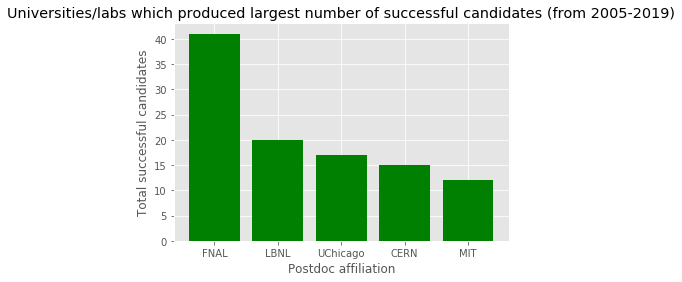

In [11]:
plt.style.use('ggplot')
u_total_success = UniversityTableAllYears.sort_values(by=['Total successful candidates'], ascending=False)

x_pos = [i for i, _ in enumerate(u_total_success['Affiliation'].iloc[:5])]

plt.bar(x_pos, u_total_success['Total successful candidates'].iloc[:5], color='green')
plt.xlabel("Postdoc affiliation")
plt.ylabel("Total successful candidates")
plt.title("Universities/labs which produced largest number of successful candidates (from 2005-2019)")

plt.xticks(x_pos, u_total_success['Affiliation'].iloc[:5])

plt.show()

FNAL (Fermilab) has a huge particle physics group especially during the tevatron days! :)

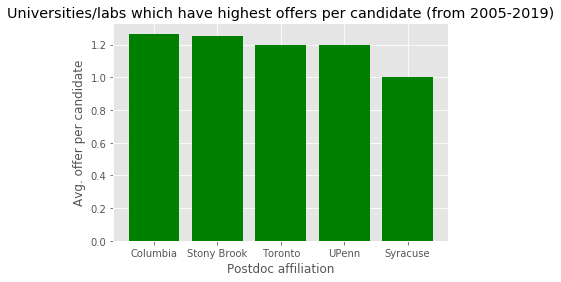

In [12]:
plt.style.use('ggplot')
x_pos = [i for i, _ in enumerate(UniversityTableAllYears['Affiliation'].iloc[:5])]

plt.bar(x_pos, UniversityTableAllYears['Offers/candidate'].iloc[:5], color='green')
plt.xlabel("Postdoc affiliation")
plt.ylabel("Avg. offer per candidate")
plt.title("Universities/labs which have highest offers per candidate (from 2005-2019)")

plt.xticks(x_pos, UniversityTableAllYears['Affiliation'].iloc[:5])

plt.show()

In [13]:
def checkmodeling(uniname):
    uni_offers = []
    UniversityTable = {}
    for i in range(2005,2020):
        UniversityTable[i] = ApplicantTable[i].sort_values(by=['Offers', 'Attempts'], ascending=False)
        UniversityTable[i] = UniversityTable[i].groupby(['Applicant', 'Affiliation'])['Attempts', 'Offers'].sum().reset_index()
        UniversityTable[i]['Success'] = (UniversityTable[i]['Offers'] > 0).astype(int)
        UniversityTable[i] = UniversityTable[i].drop(columns=['Applicant', 'Attempts'])
        UniversityTable[i]['Failure'] = (UniversityTable[i]['Offers'] == 0).astype(int)
        UniversityTable[i] = UniversityTable[i].groupby(['Affiliation'])['Offers', 'Success', 'Failure'].sum().reset_index()
        d = UniversityTable[i]
        o = d[d['Affiliation'] == uniname]['Offers']
        if (len(o.values)!=0): uni_offers.append(int(o))

    uni_offers = np.array(uni_offers)


    def factorial (n):
        if (n > 0): return n*factorial(n-1)
        else: return 1


    def poisson(k, lamb):
        """poisson pdf, parameter lamb is the fit parameter"""
        return (lamb**k/factorial(k)) * np.exp(-lamb)

    lamb = uni_offers.mean()
    uni_offers.sort()

    p = [poisson(_, lamb) for _ in range(uni_offers.max()+1)]
    binboundary = np.array(range(-1,uni_offers.max()+1)) + 0.5
    plt.hist(uni_offers, bins=binboundary, normed=True, alpha=0.5,histtype='stepfilled', color='steelblue', edgecolor='none');
    plt.plot(range(uni_offers.max()+1), p, 'ro-', label='Poiss(%.2f)'%lamb)
    plt.xlabel("offers per year")
    plt.ylabel("Arbitrary units")
    plt.title("offers/year to %s postdocs (from 2005-2019)"%uniname)
    plt.legend()
    plt.show()

Let's check for some universities/labs how well (badly) does the Poisson modeling of the offers per year work..

/home/sourav/anaconda3/envs/ML/lib/python3.6/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


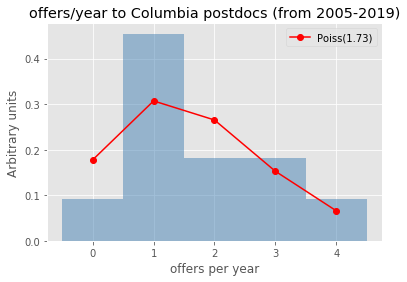

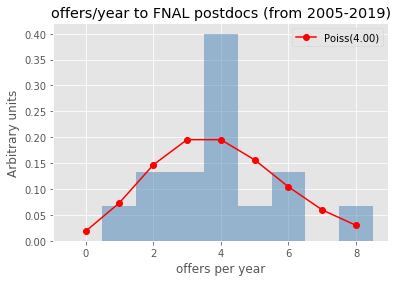

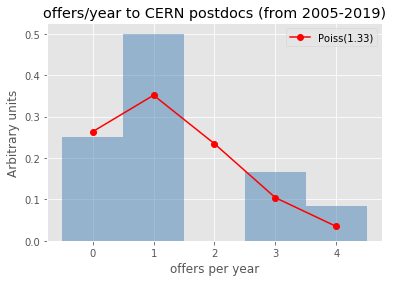

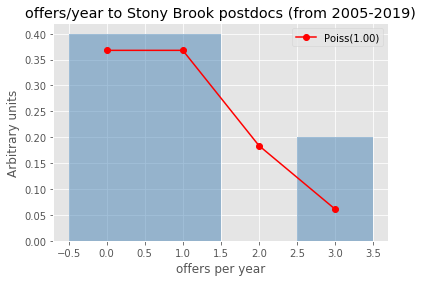

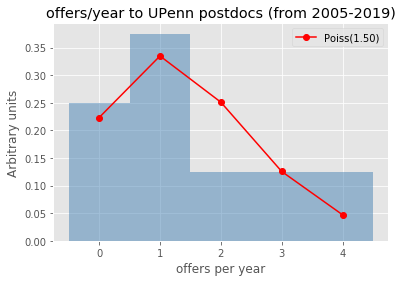

[None, None, None, None, None]

In [14]:
uninames = ['Columbia', 'FNAL', 'CERN', 'Stony Brook', 'UPenn']
[checkmodeling(uniname) for uniname in uninames]

## Postdoc Metrics

We can define individual success of a postdoc using ___postdoc metric 1___:

**Success odds** =  $\frac{total\ offers}{total\ rejections}$  (for a postdoc)

___postdoc metric 2___ is the binary form of ___postdoc metric 1___:

**Success** = 1 if (**success odds** > 0) else 0

ie, if a postdoc got at least one job offer, that postdoc is counted as successful.

Adding **success odds** to the table:

In [15]:
ApplicantTableAllYears['Success odds'] = ApplicantTableAllYears['Offers']/(ApplicantTableAllYears['Attempts'] - ApplicantTableAllYears['Offers'])
ApplicantTableAllYears = ApplicantTableAllYears[~ApplicantTableAllYears.isin([np.nan, np.inf, -np.inf]).any(1)]
ApplicantTableAllYears.head()

,Applicant,Affiliation,Attempts,Offers,Success,Success odds
220,Florencia Canelli,FNAL,15,7,1,0.875
571,Sabine Lammers,Columbia,7,5,1,2.500
86,Ben Kilminster,Ohio State,8,4,1,1.000
115,Carter Hall,SLAC,5,4,1,4.000
215,Eva Halkiadakis,Rochester,9,3,1,0.500


Checking the distribution of **success odds**:

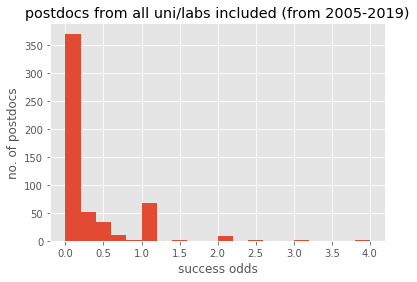

In [16]:
plt.hist(ApplicantTableAllYears['Success odds'], bins=20)
plt.xlabel("success odds")
plt.ylabel("no. of postdocs")
plt.title("postdocs from all uni/labs included (from 2005-2019)")
plt.show()

**Success odds** distributions mostly 0 (no offers) and a peak at 1 (no. of offers = no. of rejections) per candidate.

In [17]:
UniApplicantTableAllYear = ApplicantTableAllYears.merge(UniversityTableAllYears[['Affiliation', 'Offers/candidate', 'Total successful candidates', 'Total unsuccessful candidates']], how='left', left_on='Affiliation', right_on='Affiliation')
UniApplicantTableAllYear[UniApplicantTableAllYear['Success']==0].head()

,Applicant,Affiliation,Attempts,Offers,Success,Success odds,Offers/candidate,Total successful candidates,Total unsuccessful candidates
191,David Lopes Pegna,Princeton,11,0,0,0.0,0.384615,5,8
192,Sasha Telnov,Princeton,9,0,0,0.0,0.384615,5,8
193,Christopher Backhouse,Caltech,8,0,0,0.0,0.600000,3,7
194,Corrinne Mills,Harvard,7,0,0,0.0,0.600000,8,7
195,Jesse Wodin,SLAC,6,0,0,0.0,0.888889,9,9


## Postdoc metrics vs. university metric

### Postdoc metric 1 (*success odds*) vs. university metric (*offers/candidate*)

Text(0, 0.5, 'Postdoc metric: success odds')

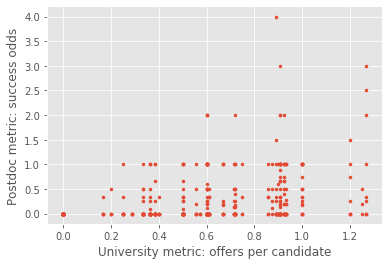

In [18]:
plt.scatter(UniApplicantTableAllYear['Offers/candidate'], UniApplicantTableAllYear['Success odds'], marker = '.')
plt.xlabel('University metric: offers per candidate')
plt.ylabel('Postdoc metric: success odds')

Pearson correlation: 

In [19]:
correlation = UniApplicantTableAllYear[['Offers/candidate', 'Success odds']]
correlation.corr()

,Offers/candidate,Success odds
Offers/candidate,1.000000,0.343269
Success odds,0.343269,1.000000


Since there are other factors contributing to a postdocs success, the variation of the *median of* ***success odds*** w.r.t ***offers/candidate*** is useful in understanding the effect of university on postdoc's success.  

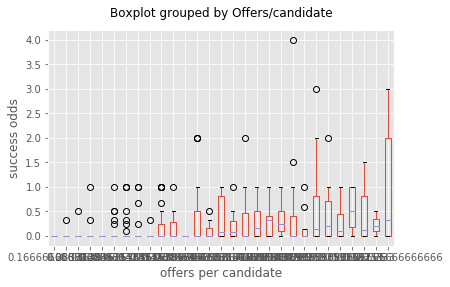

In [20]:
bp = UniApplicantTableAllYear.boxplot(column='Success odds',by='Offers/candidate')
bp.set_xlabel('offers per candidate')
bp.set_ylabel('success odds')
bp.set_title('')
bp

Homoscedasticity doesn't hold very well here

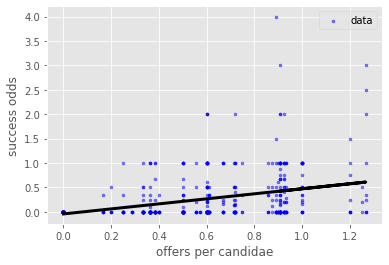

In [21]:
x = UniApplicantTableAllYear['Offers/candidate'].values
y = UniApplicantTableAllYear['Success odds'].values
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)
regr = LinearRegression()
regr.fit(x, y)
plt.scatter(UniApplicantTableAllYear['Offers/candidate'],
            UniApplicantTableAllYear ['Success odds'], alpha=0.5, 
            color='blue', marker='.', label='data')
plt.plot(x, regr.predict(x), color='black', linewidth=3)
plt.xlabel('offers per candidae')
plt.ylabel('success odds')
plt.legend()
plt.show()

In [22]:
UniApplicantTableAllYearLog = UniApplicantTableAllYear
UniApplicantTableAllYearLog['Success logit'] = np.log(UniApplicantTableAllYearLog['Success odds'])
UniApplicantTableAllYearLog = UniApplicantTableAllYearLog[~UniApplicantTableAllYearLog.isin([np.nan, np.inf, -np.inf]).any(1)]
UniApplicantTableAllYearLog.head()

/home/sourav/.local/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Applicant,Affiliation,Attempts,Offers,Success,Success odds,Offers/candidate,Total successful candidates,Total unsuccessful candidates,Success logit
0,Florencia Canelli,FNAL,15,7,1,0.875,0.909091,41,25,-0.133531
1,Sabine Lammers,Columbia,7,5,1,2.500,1.266667,12,3,0.916291
2,Ben Kilminster,Ohio State,8,4,1,1.000,0.900000,4,6,0.000000
3,Carter Hall,SLAC,5,4,1,4.000,0.888889,9,9,1.386294
4,Eva Halkiadakis,Rochester,9,3,1,0.500,0.857143,4,3,-0.693147


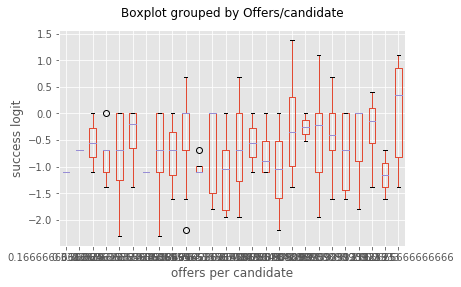

In [23]:
bp = UniApplicantTableAllYearLog.boxplot(column='Success logit',by='Offers/candidate')
bp.set_xlabel('offers per candidate')
bp.set_ylabel('success logit')
bp.set_title('')
bp

Homoscedasticity better with **success logit**.

/home/sourav/anaconda3/envs/ML/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


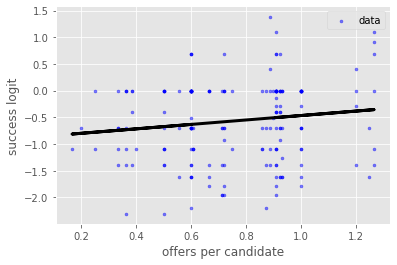

In [24]:
x = UniApplicantTableAllYearLog['Offers/candidate'].values
logy = UniApplicantTableAllYearLog['Success logit'].values
x = x.reshape(-1, 1)
logy = logy.reshape(-1, 1)
#adding column of 1 to estimate slope and intercept
UniApplicantTableAllYearLog['const'] = 1

regrOLSlog = sm.OLS(UniApplicantTableAllYearLog['Success logit'], 
                    UniApplicantTableAllYearLog[['Offers/candidate', 'const']]).fit()

regrlog = LinearRegression()
regrlog.fit(x, logy)

plt.scatter(UniApplicantTableAllYearLog['Offers/candidate'],
            UniApplicantTableAllYearLog['Success logit'], alpha=0.5, 
            color='blue', marker='.', label='data')
plt.plot(x, regrlog.predict(x), color='black', linewidth=3)
plt.xlabel('offers per candidate')
plt.ylabel('success logit')
plt.legend()
plt.show()

In [25]:
## slope of the regression
slope = regrlog.coef_[0][0]

## intercept of the regression
intercept = regrlog.intercept_[0]

## R^2 value
rsq = regrlog.score(x, logy)

slope, intercept, rsq

(0.4155776204426254, -0.8826111233324048, 0.018266248086799997)

In [26]:
print(regrOLSlog.summary())

                            OLS Regression Results                            
Dep. Variable:          Success logit   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     3.517
Date:                Sat, 12 Oct 2019   Prob (F-statistic):             0.0623
Time:                        08:18:13   Log-Likelihood:                -212.57
No. Observations:                 191   AIC:                             429.1
Df Residuals:                     189   BIC:                             435.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Offers/candidate     0.4156      0.222  

p-value of 0.062 for the slope of the linear regression suggests that the dependence of **success logit** on **offers/candidate** is ***NOT*** _statistically significant_ with 95% CL. So, the role of university in the success of its postdocs cannot be established with statistical significance using this pair of university and postdoc metrics.

### Postdoc metric 2 (*success*) vs. university metric (*offers/candidate*)

In [27]:
UniApplicantTableAllYear.head()

,Applicant,Affiliation,Attempts,Offers,Success,Success odds,Offers/candidate,Total successful candidates,Total unsuccessful candidates,Success logit
0,Florencia Canelli,FNAL,15,7,1,0.875,0.909091,41,25,-0.133531
1,Sabine Lammers,Columbia,7,5,1,2.500,1.266667,12,3,0.916291
2,Ben Kilminster,Ohio State,8,4,1,1.000,0.900000,4,6,0.000000
3,Carter Hall,SLAC,5,4,1,4.000,0.888889,9,9,1.386294
4,Eva Halkiadakis,Rochester,9,3,1,0.500,0.857143,4,3,-0.693147


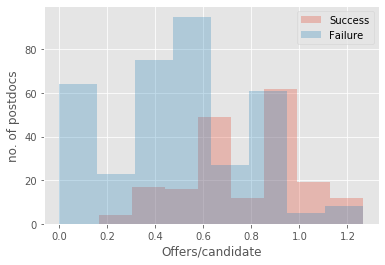

In [28]:
t = UniApplicantTableAllYear[['Offers/candidate', 'Success']]
t = t.sort_values(by=['Offers/candidate'], ascending=False)
tsuccess = t[t['Success'] == 1]
tfailure = t[t['Success'] == 0]

bins=8
plt.hist(tsuccess['Offers/candidate'], bins, alpha=0.3, label='Success')
plt.hist(tfailure['Offers/candidate'], bins, alpha=0.3, label='Failure')

plt.xlabel('Offers/candidate')
plt.ylabel('no. of postdocs')
plt.legend(loc='best')
plt.show()

In [53]:
logisticRegr = linear_model.LogisticRegression(C=1e5, solver='lbfgs')
logisticRegr.fit(UniApplicantTableAllYear[['Offers/candidate']], UniApplicantTableAllYear['Success'])
logisticRegr.score(UniApplicantTableAllYear[['Offers/candidate']], UniApplicantTableAllYear['Success'])

0.6867030965391621

In [62]:
print(logisticRegr.coef_[0][0], logisticRegr.intercept_[0])

3.105024677567668 -2.582806084094838


In [54]:
#xLR = np.arange(UniApplicantTableAllYear['Offers/candidate'].min(), 
#          UniApplicantTableAllYear['Offers/candidate'].max(), 0.01)
xLR = np.arange(-0.5, 2, 0.01)
xLR = xLR.reshape(-1,1)

No handles with labels found to put in legend.


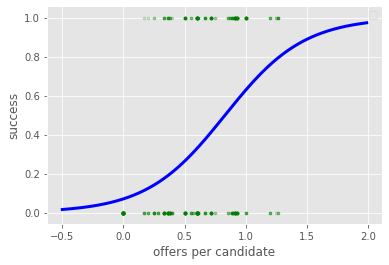

In [63]:
from scipy.special import expit
logistic = expit(xLR * logisticRegr.coef_ + logisticRegr.intercept_).ravel()
plt.scatter(UniApplicantTableAllYear['Offers/candidate'], 
            UniApplicantTableAllYear['Success'], marker='.', alpha = 0.2, color='green')
plt.plot(xLR, logistic, color='blue', linewidth=3)
plt.xlabel('offers per candidate')
plt.ylabel('success')
plt.legend()
plt.show()

**offers per candidate** metric is not very good in discriminating postdocs into successful (at least one job offer) and unsuccessful candidates, as the accuracy is ~69%.

## Summary
* Statistically significant relationship between **Offers/candidate**, the _university metric_, and the _postdoc metrics_ could not be established.
* We could not establish, with statisical significance, if the affiliation of a experimental high energy physics (hepex) postdoc is an indicator of future success in finding permanent academic position.

# Future steps

* temporal variations in hep-ex job market not taken into account
* US and non-US jobs to be treated separately
* should separate the study into energy, intensity and cosmic frontiers, as the job trends and funding are different for each
* Look into other indicators of postdoc success like research productivity, etc.